In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install warnings
!pip install dgl
!pip install texttable

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.3/497.3 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.7/745.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 25.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 14.7 MB/s eta 0:00:00
cpu


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!pip install torch-cluster

In [3]:
import random
from torchvision import transforms, datasets

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np

import dgl
import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)

    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)

    # Convert to symmetric matrix
    A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d
class newCIFARSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        #self.split = split
        #self.is_test = split.lower() in ['test', 'val']
        with open(data_dir, 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 32

    def precompute_graph_images(self):
        #print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]

            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features

            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

use_feat_for_graph_construct = False
#tt = time.time()
data_with_feat_knn = newCIFARSuperPix('/content/drive/MyDrive/CMINST_data/CMNIST10000_75sp_test.pkl',use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()
testing_data = np.load('/content/drive/MyDrive/CMINST_data/colorMNIST10000_test_data.npy')
testing_label=np.load('/content/drive/MyDrive/CMINST_data/colorMNIST10000_test_label.npy')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
import numpy as np
import os.path as osp
import pickle
import torch
import torch.utils
import torch.utils.data
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import InMemoryDataset,Data
#/content/drive/MyDrive/Colab_Notebooks/mnist08_83_75sp_train.pkl
def compute_adjacency_matrix_images(coord, sigma=0.1):
    coord = coord.reshape(-1, 2)
    dist = cdist(coord, coord)
    A = np.exp(- dist / (sigma * np.pi) ** 2)
    A[np.diag_indices_from(A)] = 0
    return A


def list_to_torch(data):
    for i in range(len(data)):
        if data[i] is None:
            continue
        elif isinstance(data[i], np.ndarray):
            if data[i].dtype == np.bool:
                data[i] = data[i].astype(np.float32)
            data[i] = torch.from_numpy(data[i]).float()
        elif isinstance(data[i], list):
            data[i] = list_to_torch(data[i])
    return data
def process(data_file):
  use_mean_px=True
  use_coord=True
  node_gt_att_threshold=0
  transform=None
  pre_transform=None
  pre_filter=None

  #data_file ='/content/drive/MyDrive/Colab_Notebooks/colorMNIST05_2000_75sp_train.pkl'

  with open(osp.join(data_file), 'rb') as f:
      labels,sp_data = pickle.load(f)

  #use_mean_px = self.use_mean_px
  #self.use_coord = self.use_coord
  n_samples = len(labels)
  img_size = 32
  #node_gt_att_threshold = self.node_gt_att_threshold

  edge_indices,xs,edge_attrs,node_gt_atts,edge_gt_atts = [], [], [], [], []
  data_list = []
  for index, sample in enumerate(sp_data):
      mean_px, coord = sample[:2]
      coord = coord / img_size
      A = compute_adjacency_matrix_images(coord)
      N_nodes = A.shape[0]

      A = torch.FloatTensor((A > 0.1) * A)
      edge_index, edge_attr = dense_to_sparse(A)

      x = None
      if use_mean_px:
          x = mean_px.reshape(N_nodes, -1)
      if use_coord:
          coord = coord.reshape(N_nodes, 2)
          if use_mean_px:
              x = np.concatenate((x, coord), axis=1)
          else:
              x = coord
      if x is None:
          x = np.ones(N_nodes, 1)  # dummy features

      # replicate features to make it possible to test on colored images
      x = np.pad(x, ((0, 0), (2, 0)), 'edge')
      if node_gt_att_threshold == 0:
          node_gt_att = (mean_px > 0).astype(np.float32)
      else:
          node_gt_att = mean_px.copy()
          node_gt_att[node_gt_att < node_gt_att_threshold] = 0

      node_gt_att = torch.LongTensor(node_gt_att).view(-1)
      row, col = edge_index
      edge_gt_att = torch.LongTensor(node_gt_att[row] * node_gt_att[col]).view(-1)

      data_list.append(
          Data(
              x=torch.tensor(x),
              y=torch.LongTensor([labels[index]]),
              edge_index=edge_index,
              edge_attr=edge_attr,
              node_gt_att=node_gt_att,
              edge_gt_att=edge_gt_att

          )
      )

  #torch.save(InMemoryDataset.collate(data_list), '/content/drive/MyDrive/Colab_Notebooks/colorMINST05_2000.pt')
  return data_list

In [5]:
train_dir='/content/drive/MyDrive/CMINST_data/CMNIST08_10000_75sp_train.pkl'
val_dir='/content/drive/MyDrive/CMINST_data/CMNIST5000_75sp_val.pkl'
test_dir='/content/drive/MyDrive/CMINST_data/CMNIST10000_75sp_test.pkl'
training_final=process(data_file=train_dir)
valing_final=process(data_file=val_dir)
testing_final=process(data_file=test_dir)



In [6]:
import torch
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.nn.inits import glorot, zeros
import pdb

In [10]:
import torch
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.nn.inits import glorot, zeros
import pdb

def mask_graph(graph_x,select_node):
  mask_value=np.array([0.0001]*32)
  result=np.array([t.detach().numpy() for t in graph_x])
  for i in range(graph_x.shape[0]):
    if(i in select_node):
      continue
    result[i]=mask_value
  return torch.tensor(result)




class GCNConv(MessagePassing):

    def __init__(self,
                 in_channels,
                 out_channels,
                 improved=False,
                 cached=False,
                 bias=True,
                 edge_norm=True,
                 gfn=False):
        super(GCNConv, self).__init__('add')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.cached_result = None
        self.edge_norm = edge_norm
        self.gfn = gfn
        self.message_mask = None
        self.weight = Parameter(torch.Tensor(in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)
        self.cached_result = None

    @staticmethod
    def norm(edge_index, num_nodes, edge_weight, improved=False, dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ),
                                     dtype=dtype,
                                     device=edge_index.device)

        edge_weight = edge_weight.view(-1)


        assert edge_weight.size(0) == edge_index.size(1)

        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
        # Add edge_weight for loop edges.
        loop_weight = torch.full((num_nodes, ),
                                 1 if not improved else 2,
                                 dtype=edge_weight.dtype,
                                 device=edge_weight.device)
        edge_weight = torch.cat([edge_weight, loop_weight], dim=0)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    def forward(self, x, edge_index, edge_weight=None):
        """"""

        x = torch.matmul(x, self.weight)
        if self.gfn:
            return x

        if not self.cached or self.cached_result is None:
            if self.edge_norm:
                edge_index, norm = GCNConv.norm(
                    edge_index,
                    x.size(0),
                    edge_weight,
                    self.improved,
                    x.dtype)
            else:
                norm = None
            self.cached_result = edge_index, norm

        edge_index, norm = self.cached_result
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):

        if self.edge_norm:
            return norm.view(-1, 1) * x_j
        else:
            return x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [7]:
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Sequential, ReLU
from torch_geometric.nn import global_mean_pool, global_add_pool, GINConv, GATConv,GCNConv

import random
import pdb
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

layers=3
with_random=True
fc_num=222
hidden=32
eval_random=False
class GATNet(torch.nn.Module):
    def __init__(self, num_features,
                       num_classes,
                       hidden=32,
                       head=4,
                       num_fc_layers=2,
                       num_conv_layers=3,
                       dropout=0.2):

        super(GATNet, self).__init__()

        self.global_pool = global_add_pool
        self.dropout = dropout
        hidden_in = num_features
        hidden_out = num_classes

        self.bn_feat = BatchNorm1d(hidden_in)
        self.conv_feat = GATConv(hidden_in, hidden, gfn=True) # linear transform
        self.bns_conv = torch.nn.ModuleList()
        self.convs = torch.nn.ModuleList()

        for i in range(num_conv_layers):
            self.bns_conv.append(BatchNorm1d(hidden))
            self.convs.append(GATConv(hidden, int(hidden / head), heads=head, dropout=dropout))
        self.bn_hidden = BatchNorm1d(hidden)
        self.bns_fc = torch.nn.ModuleList()
        self.lins = torch.nn.ModuleList()

        for i in range(num_fc_layers - 1):
            self.bns_fc.append(BatchNorm1d(hidden))
            self.lins.append(Linear(hidden, hidden))
        self.lin_class = Linear(hidden, hidden_out)

        # BN initialization.
        for m in self.modules():
            if isinstance(m, (torch.nn.BatchNorm1d)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0.0001)

    def forward(self, data):

        x = data.x if data.x is not None else data.feat
        edge_index, batch = data.edge_index, data.batch

        x = self.bn_feat(x)
        x = F.relu(self.conv_feat(x, edge_index))

        for i, conv in enumerate(self.convs):
            x = self.bns_conv[i](x)
            x = F.relu(conv(x, edge_index))
        mp=x.clone()
        x = self.global_pool(x, batch)
        for i, lin in enumerate(self.lins):
            x = self.bns_fc[i](x)
            x = F.relu(lin(x))

        x = self.bn_hidden(x)
        if self.dropout > 0:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin_class(x)
        return F.log_softmax(x, dim=-1)

In [8]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import DataLoader, DenseDataLoader as DenseLoader
from torch import tensor
import torch_geometric.transforms as T
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
import pdb
import random
import numpy as np
from torch.autograd import grad
from torch_geometric.data import Batch


In [9]:
train_loader = DataLoader(training_final, batch_size=128, shuffle=True)
val_loader = DataLoader(valing_final, batch_size=128, shuffle=False)
test_loader = DataLoader(testing_final, batch_size=128, shuffle=False)
#t_load=[]
#for i in train_loader:
#  t_load.append(i)
#  if(len(t_load)==10000):
#    break


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
number_of_class=10
Epo=500
model= GATNet(7,number_of_class).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=Epo, eta_min=1e-6, last_epoch=-1, verbose=False)


In [ ]:
checkpoint2= torch.load('/content/drive/MyDrive/running_nodebias_mnist/GATmodel_08.pt')
model.load_state_dict(checkpoint2['GCN_model.state_dic'])

<All keys matched successfully>

In [11]:
import time
import json

loss_value=[]
loss_value_valation=[]

def num_graphs(data):
  if data.batch is not None:
      return data.num_graphs
  else:
      return data.x.size(0)
from tqdm import tqdm

for epoch in range(Epo):
  model.train()
  total_loss = 0
  correct = 0
  nb=0
  print(f"-----training-------{epoch}")
  loop = tqdm(enumerate(train_loader),total=len(train_loader))
  for it, data in loop:
#  for it, data in enumerate(train_loader):
      nb+=1
      optimizer.zero_grad()
      data = data.to(device)
      out = model(data)
      loss = F.nll_loss(out, data.y.view(-1))
      pred = out.max(1)[1]
      correct += pred.eq(data.y.view(-1)).sum().item()
      loss.backward()
      total_loss += loss.item() #* num_graphs(data)
      optimizer.step()
      loop.set_description(f"Epoch [{epoch}/{Epo}]")
      loop.set_postfix(loss = loss.item())

  #num = len(train_loader.dataset)
  total_loss = total_loss / nb
  lr_scheduler.step()

  print(f'number of {epoch} with total loss:{total_loss}')
  loss_value.append(total_loss)
  correct = correct / nb
  with torch.no_grad():
    model.eval()
    correct = 0
    print(f"------valation---------{epoch}")
    for data in val_loader:
      data = data.to(device)
      pred = model(data).max(1)[1]
      correct += pred.eq(data.y.view(-1)).sum().item()
    acc_o = correct / len(val_loader.dataset)
    print(f"causal val accuracy:{acc_o}")
    loss_value_valation.append(acc_o)
    dictionary={"number of epoch":epoch,
                "training loss list":loss_value,
                "valation accuracy list":loss_value_valation}

    # Serializing json
    json_object = json.dumps(dictionary,indent=3)

    # Writing to sample.json
    #with open("/content/drive/MyDrive/running_nodebias_mnist/numberGAT_tl_va_e09.json", "w") as outfile:
    #    outfile.write(json_object)

    #torch.save(causal_model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/430cau_my6000.pt')
    #torch.save(predictco_model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/430caupred_my6000.pt')
    #torch.save(predictno_model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/430noncaupred_my6000.pt')
    #torch.save(model_heter.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/430heter6000.pt')
   # torch.save({
   #         'GCN_model.state_dic': model.state_dict(),
   #         'opt':optimizer.state_dict()
   #         }, '/content/drive/MyDrive/running_nodebias_mnist/GATmodel_09.pt')
    if(epoch>25):
      check=abs(acc_o-loss_value_valation[len(loss_value_valation)-20])/20
      if(check<=0.001):
        break




-----training-------0


Epoch [0/500]: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s, loss=0.966]


number of 0 with total loss:1.3416522492336322
------valation---------0
causal val accuracy:0.0893
-----training-------1


Epoch [1/500]: 100%|██████████| 79/79 [00:13<00:00,  5.99it/s, loss=1.02]


number of 1 with total loss:0.9951883803440046
------valation---------1
causal val accuracy:0.0965
-----training-------2


Epoch [2/500]: 100%|██████████| 79/79 [00:12<00:00,  6.38it/s, loss=1.2]


number of 2 with total loss:0.958868219882627
------valation---------2
causal val accuracy:0.098
-----training-------3


Epoch [3/500]: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s, loss=1.51]


number of 3 with total loss:0.9343175646624987
------valation---------3
causal val accuracy:0.1019
-----training-------4


Epoch [4/500]: 100%|██████████| 79/79 [00:11<00:00,  7.12it/s, loss=0.867]


number of 4 with total loss:0.9055277607108974
------valation---------4
causal val accuracy:0.0991
-----training-------5


Epoch [5/500]: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s, loss=1]


number of 5 with total loss:0.8838619672799413
------valation---------5
causal val accuracy:0.0989
-----training-------6


Epoch [6/500]: 100%|██████████| 79/79 [00:12<00:00,  6.38it/s, loss=1.05]


number of 6 with total loss:0.8629788567748251
------valation---------6
causal val accuracy:0.102
-----training-------7


Epoch [7/500]: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s, loss=1.05]


number of 7 with total loss:0.8427027456368072
------valation---------7
causal val accuracy:0.1147
-----training-------8


Epoch [8/500]: 100%|██████████| 79/79 [00:12<00:00,  6.35it/s, loss=2.22]


number of 8 with total loss:0.847263095499594
------valation---------8
causal val accuracy:0.1245
-----training-------9


Epoch [9/500]:  34%|███▍      | 27/79 [00:04<00:08,  5.94it/s, loss=0.841]


KeyboardInterrupt: 

In [ ]:
  #model_optimizer.zero_grad()
  #total_loss.backward()
  #model_optimizer.step()
test_loader = DataLoader(testing_final, batch_size=1, shuffle=False)

model.eval()
correct = 0
print(f"------test---------{00}")
for data in test_loader:
  data = data.to(device)
  pred = model(data).max(1)[1]
  correct += pred.eq(data.y.view(-1)).sum().item()
acc_o = correct / len(test_loader.dataset)
print(f"causal val accuracy:{acc_o}")
dictionary={"number of epoch":epoch,
        "training loss list":loss_value,
        "valation accuracy list":loss_value_valation,
        "test accuracy value":acc_o}

# Serializing json
json_object = json.dumps(dictionary,indent=4)

# Writing to sample.json
with open("/content/drive/MyDrive/running_nodebias_mnist/numberGAT_tl_va_e08.json", "w") as outfile:
  outfile.write(json_object)

In [ ]:
t=[]
test_loader = DataLoader(testing_final, batch_size=1, shuffle=False)
for i in test_loader:
  t.append(i)


In [ ]:
model.eval()
a,b=model(t[0])
torch.topk(b.sum(axis=1),10)[1]

tensor([13,  7, 26, 22, 40, 23, 20, 38,  1, 47])

In [ ]:
c=[]
my=[]
model.eval()
correct = 0
print(f"------test---------{00}")
for data in test_loader:
  data = data.to(device)
  w=torch.topk(data.x.sum(axis=1),10)[1]
  c.append(w.tolist())
  pred,m = model(data)
  w2=torch.topk(m.sum(axis=1),10)[1]
  my.append(w2.tolist())
  pred=pred.max(1)[1]
  correct += pred.eq(data.y.view(-1)).sum().item()
acc_o = correct / len(test_loader.dataset)
print(f"causal val accuracy:{acc_o}")

------test---------0
causal val accuracy:0.7572


In [ ]:
from sklearn.metrics import f1_score

z=0
for i in range(10000):
  z+=f1_score(c[i],my[i], average='macro')
z

43.006431189210225

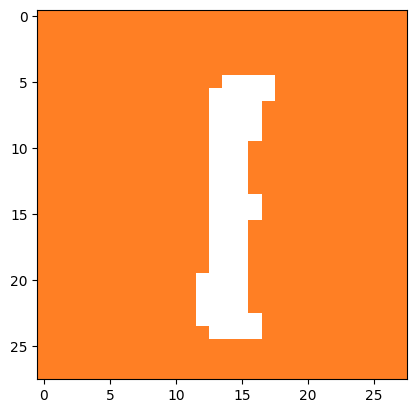

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [25]:
testing_data[1].shape
plt.imshow(testing_data[1])
plt.show()
idex=1
sp_data=data_with_feat_knn.sp_data[idex]
adj_matrix=data_with_feat_knn.Adj_matrices[idex]
label=data_with_feat_knn[idex][1]
feat_coord=data_with_feat_knn.use_feat_for_graph

In [27]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams

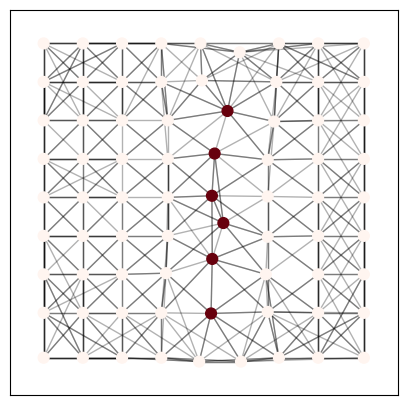

In [29]:
with_edges=True
plt.figure(figsize=(5, 5))
real=True
Y = squareform(pdist(sp_data[1], 'euclidean'))
x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
#intensities = sp_data[0].mean(axis=1)
#label = classes[label]
if real:
  intensities = sp_data[0].mean(axis=1)
else:
  intensities=np.array(g.mean(axis=1).cpu().detach())
  #intensities=np.array([0]*sp_data[0].shape[0])
  #intensities[[10]]=1




G = nx.from_numpy_array(Y)
pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree

edge_list = []
for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
    for dst in dsts:
        edge_list.append((src, dst))

nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
if with_edges:
    nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)